In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = 'cuda:0'

Mon Jan 15 03:39:58 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   27C    P2    53W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Dataset

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
test_loader = DataLoader(mnist_testset, batch_size=10000, shuffle=False)

### Preprocess
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

batch = next(iter(test_loader))
data = preprocess(batch)
print(data.keys())

dict_keys(['x', 't'])


### Model Parts

In [4]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.uniform_min_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [5]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [6]:
model_list = []
for i in range(10):
    model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
    model = model.to(device)
    model.eval()
    model_list.append(model)
    
print('done')

done


### Load

In [7]:
!ls -lt /data/scpark/save/lse/train01.14-4/

total 4833388
-rw-rw-r-- 1 scpark scpark  11955704  1월 15 03:40 events.out.tfevents.1705221569.GPUSVR01
-rw-rw-r-- 1 scpark scpark 379803125  1월 15 03:29 save_120000
-rw-rw-r-- 1 scpark scpark 379803125  1월 15 02:40 save_110000
-rw-rw-r-- 1 scpark scpark 379803125  1월 15 01:50 save_100000
-rw-rw-r-- 1 scpark scpark 379800983  1월 15 01:01 save_90000
-rw-rw-r-- 1 scpark scpark 379800983  1월 15 00:11 save_80000
-rw-rw-r-- 1 scpark scpark 379800983  1월 14 23:21 save_70000
-rw-rw-r-- 1 scpark scpark 379800983  1월 14 22:32 save_60000
-rw-rw-r-- 1 scpark scpark 379800983  1월 14 21:44 save_50000
-rw-rw-r-- 1 scpark scpark 379800983  1월 14 20:55 save_40000
-rw-rw-r-- 1 scpark scpark 379800983  1월 14 20:07 save_30000
-rw-rw-r-- 1 scpark scpark 379800983  1월 14 19:19 save_20000
-rw-rw-r-- 1 scpark scpark 379800983  1월 14 18:29 save_10000
-rw-rw-r-- 1 scpark scpark 379787295  1월 14 17:39 save_0
-rw-rw-r-- 1 scpark scpark        40  1월 14 17:39 events.out.tfevents.1705221153.GPUSVR01
-rw-rw-r-- 1 s

In [8]:
from tqdm import tqdm_notebook as tqdm

save_path = '/data/scpark/save/lse/train01.14-4/save_120000'

# warm start
models_state_dict = torch.load(save_path, map_location=torch.device('cpu'))['models_state_dict']
for i, model in tqdm(enumerate(model_list)):
    model.load_state_dict(models_state_dict[i], strict=True)

0it [00:00, ?it/s]

### Reconstruction Loss

In [9]:
z_list = []
recon_loss_list = []
for model in tqdm(model_list):
    with torch.no_grad():
        data = model(data, M=1)
        z_list.append(data['z'])
        recon_loss_list.append(data['recon_loss'].item())
        
print('Reconstruction Loss :', np.mean(recon_loss_list))

  0%|          | 0/10 [00:00<?, ?it/s]

Reconstruction Loss : 0.11681306213140488


### Linear Classification Test

In [11]:
def get_linear_classification_test(z, t, n_steps=1000):
    from model.classifier.linear_classifier import Classifier
    accuracy_list = []
    classifier = Classifier(2, 10)
    classifier = classifier.to(device)
    classifier.train()
    optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3)
    
    data = {'z': z, 't': t}
    for _ in tqdm(range(n_steps)):
        data = classifier(data)
        loss = data['cross_entropy_loss']
        loss.backward()
        optimizer.step()
        accuracy_list.append(data['accuracy'].item())
    return accuracy_list

print('done')

done


  0%|          | 0/1000 [00:00<?, ?it/s]

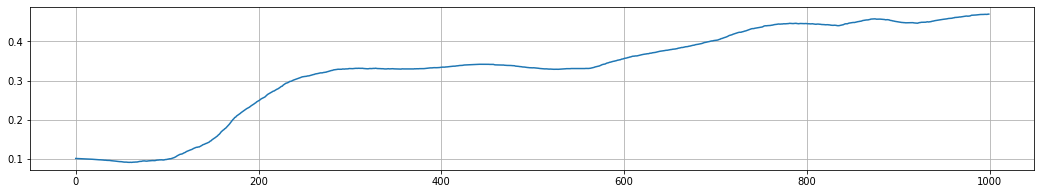

Accuracy : 0.4697999954223633


In [12]:
import matplotlib.pyplot as plt

accuracys = []
for z in z_list[:1]:
    accuracy_list = get_linear_classification_test(z, data['t'])
    accuracys.append(accuracy_list[-1])
    plt.figure(figsize=[18, 3])
    plt.plot(accuracy_list)
    plt.grid()
    plt.show()
    
print('Accuracy :', np.mean(accuracys))

### Two-Linear Classification Test

In [13]:
def get_two_linear_classification_test(z, t, n_steps=1000):
    from model.classifier.two_linear_classifier import Classifier
    accuracy_list = []
    classifier = Classifier(2, 512, 10)
    classifier = classifier.to(device)
    classifier.train()
    optimizer = torch.optim.AdamW(classifier.parameters(), lr=1e-3)
    
    data = {'z': z, 't': t}
    for _ in tqdm(range(n_steps)):
        data = classifier(data)
        loss = data['cross_entropy_loss']
        loss.backward()
        optimizer.step()
        accuracy_list.append(data['accuracy'].item())
    return accuracy_list

print('done')

done


  0%|          | 0/1000 [00:00<?, ?it/s]

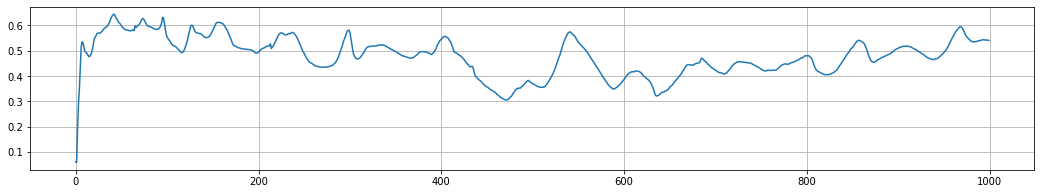

Accuracy : 0.5406999588012695


In [14]:
import matplotlib.pyplot as plt

accuracys = []
for z in z_list[:1]:
    accuracy_list = get_two_linear_classification_test(z, data['t'])
    accuracys.append(accuracy_list[-1])
    plt.figure(figsize=[18, 3])
    plt.plot(accuracy_list)
    plt.grid()
    plt.show()
    
print('Accuracy :', np.mean(accuracys))

### Silhouette Score Test

In [15]:
from sklearn.metrics import silhouette_score

scores = []
for z in tqdm(z_list):
    _z = z.data.cpu().numpy()
    _t = data['t'].data.cpu().numpy()
    score = silhouette_score(_z, _t)
    scores.append(score)
    
print('Silhouette Score :', np.mean(scores))

  0%|          | 0/10 [00:00<?, ?it/s]

Silhouette Score : 0.14501037


### MMD Test

In [ ]:
from test_util.mmd_loss import MMDLoss

mmd_losses = []
mmd = MMDLoss()
for z in tqdm(z_list):
    prior = (torch.rand_like(z) * 2) - 1
    mmd_loss = mmd(prior.to('cpu'), z.to('cpu'))
    mmd_losses.append(mmd_loss.item())
    
print('MMD Loss :', np.mean(mmd_losses))    

  0%|          | 0/10 [00:00<?, ?it/s]

In [18]:
mmd_losses

[0.25444936752319336,
 0.275073766708374,
 0.26433277130126953,
 0.26833224296569824,
 0.264815092086792,
 0.2671036720275879,
 0.26082873344421387,
 0.271881103515625,
 0.2646219730377197,
 0.2845492362976074]

### View Embeddings

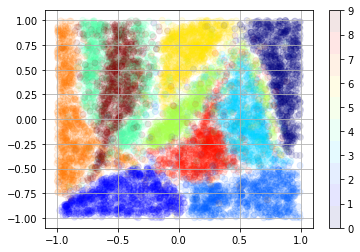

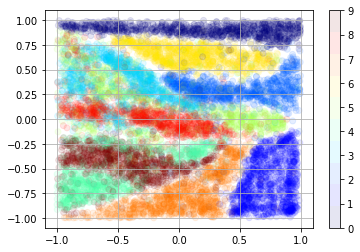

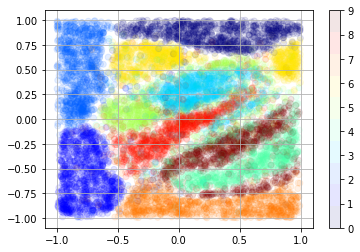

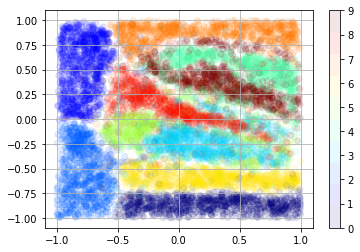

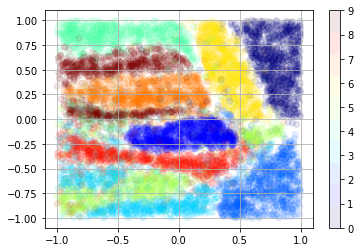

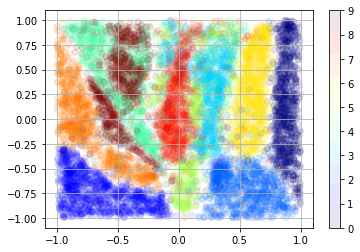

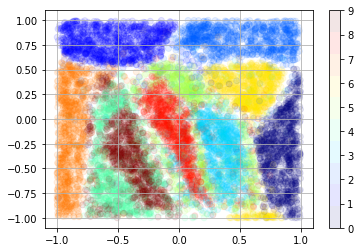

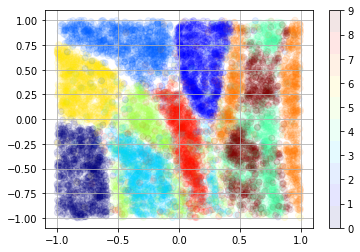

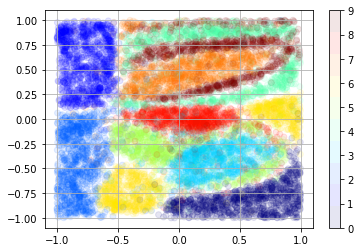

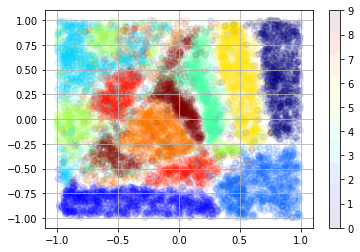

In [17]:
import matplotlib.pyplot as plt

# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


for z in z_list:
    _z = z.data.cpu().numpy()
    plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'), alpha=0.1)
    plt.grid()
    plt.colorbar()
    plt.show()